## Imports

In [16]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp

from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import xarray as xr
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import librosa

from IPython.display import Audio

DTYPE = torch.float32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(DTYPE)

torch.cuda.device_count()

4

## Classes

In [17]:
class SIREN(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.activation_scale = cfg.activation_scale
        self.dropout = cfg.dropout
        
        self.input_layer = nn.Linear(cfg.input_dim, cfg.layers[0])
        self.layers = nn.ModuleList([nn.Linear(cfg.layers[i], cfg.layers[i+1]) for i in range(len(cfg.layers)-1)])
        self.output_layer = nn.Linear(cfg.layers[-1], cfg.output_dim)

    def forward(self, x):
        out = self.input_layer(x)
        out = torch.sin(self.activation_scale * out)
        for layer in self.layers:
            out = layer(out)
            out = torch.sin(self.activation_scale * out)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.output_layer(out)
        return out
    
class MatrixFactorization(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        dim1, dim2, channels = cfg.image_shape
        self.W = nn.Parameter(torch.rand(dim1, cfg.rank, channels, dtype=DTYPE) - 0.5)
        self.H = nn.Parameter(torch.rand(cfg.rank, dim2, channels, dtype=DTYPE) - 0.5)

    def forward(self):  # train_x and train_y are ignored
        img = torch.vmap(lambda w, h: w@h, in_dims=(2, 2), out_dims=2)(self.W, self.H)  # height x rank x channels @ rank x width x channels = height x width x channels
        return img # height x width -> height x width x 1
    
class Tracer:
    pass

class Config:
    pass

class MeanModel:
    def fit(self, X, y):
        self.mean = np.mean(y)
        return self
        
    def predict(self, X):
        return np.full((X.shape[0], 1), self.mean)

## Methods

In [18]:
def first_layer_init(m):
    if hasattr(m, 'weight'):
        input_size = m.weight.size(-1)
        m.weight.uniform_(-1 / input_size, 1 / input_size)

def other_layer_init(m):
    if hasattr(m, 'weight'):
        input_size = m.weight.size(-1)
        m.weight.uniform_(-np.sqrt(6 / input_size) / 30, np.sqrt(6 / input_size) / 30)

def initialize(model):
    with torch.no_grad():
        model.input_layer.apply(first_layer_init)
        model.layers.apply(other_layer_init)
        model.output_layer.apply(other_layer_init)

def loss_fn(pred, target):
    return ((pred - target)**2).mean()

def fit(cfg, tracer, train_x, train_y, mask):
    torch.manual_seed(cfg.key)

    model = cfg.model_class(cfg).to(cfg.device)
    if cfg.model_class is SIREN:
        initialize(model)

    tracer.num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of parameters: {tracer.num_params}")
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    losses = []

    pbar = tqdm(range(cfg.iterations))
    model.train()
    for i in pbar:
        optimizer.zero_grad()
        if isinstance(model, SIREN):
            pred = model(train_x)
        elif isinstance(model, MatrixFactorization):
            pred = model()
        else:
            raise("This error should never occur")
        train_loss = loss_fn(pred, train_y)
        for param in model.parameters():
            if cfg.regularization == "l1":
                train_loss += cfg.lmd * param.square().sqrt().sum()
            elif cfg.regularization == "l2":
                train_loss += cfg.lmd * param.square().sum()
            
        train_loss.backward()
        optimizer.step()
        
        # losses.append(train_loss.item())
        # pbar.set_description(f"Loss: {losses[-1]:.6f}")

    # model.eval()
    # with torch.no_grad():
    #     if isinstance(model, SIREN):
    #         if cfg.mc_dropout:
    #             pred_dist = model(train_x)[..., None].repeat(1, 1, 1, cfg.num_mc_samples)
    #             model.train() # enable dropout
    #             for idx in range(cfg.num_mc_samples):
    #                 pred_dist[..., idx] = model(train_x)
    #             pred = pred_dist.mean(dim=-1)
    #             pred_std = pred_dist.std(dim=-1)
    #             tracer.pred_std = pred_std
                
    #     elif isinstance(model, MatrixFactorization):
    #         pred = model()
    #     else:
    #         raise("This error should never occur")
    #     print(pred.shape, mask.shape)

    return model, losses

def scaling_fn(img, factor):
    img = img.permute(2, 0, 1)
    size = (factor, factor)
    img = F.avg_pool2d(img, kernel_size=size, stride=size)
    img = img.permute(1, 2, 0)
    return img

def load_image(path, scale_down_factor, grayscale):
    img = plt.imread(path)
    if grayscale:
        img = img.mean(axis=2, keepdims=True)
    img = img / 255.0
    img = torch.tensor(img, dtype=DTYPE)
    img = scaling_fn(img, scale_down_factor)

    return img

def prepare_x_y_data(img):
    X, Y = torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]))
    X, Y = X[..., None], Y[..., None]
    return X, Y

def prepare_x_data(audio):
    X = torch.linspace(-100, 100, audio.shape[0])
    X = X[..., None]
    return X

def run(cfg, tracer):
    img = load_image(cfg.path, cfg.scale_down_factor, cfg.grayscale)
    tracer.img = img

    X, Y = prepare_x_y_data(img)
    train_x = torch.cat([X, Y], dim=-1)
    tracer.train_x = train_x

    if cfg.structured_missing:
        mask = torch.ones_like(img, dtype=torch.bool)
        mask[::2, ::2, :] = False
        print(f"{mask.sum()=}")
        # num_drop_rows = int(img.shape[0] * cfg.test_fraction/2)
        # num_drop_cols = int(img.shape[1] * cfg.test_fraction/2)
        # mask = torch.ones_like(img, dtype=torch.bool)
        # drop_rows = torch.randperm(img.shape[0])[:num_drop_rows]
        # drop_cols = torch.randperm(img.shape[1])[:num_drop_cols]
        # mask[drop_rows, :] = False
        # mask[:, drop_cols] = False
    else:
        mask = torch.rand(img.shape) < cfg.test_fraction
    
    tracer.mask = mask
    
    print(f"{train_x.shape=}, {img.shape=}")
    train_x = torch.cat([train_x[:, :, 0:1][~mask][..., None], train_x[:, :, 1:2][~mask][..., None]], dim=-1)
    img = img[~mask][..., None]

    print(f"z {train_x.shape=}, {img.shape=}")
    model, losses = fit(cfg, tracer, train_x.to(cfg.device), img.to(cfg.device), mask.to(cfg.device))

    return model, losses, tracer

def run_audio(cfg, tracer):
    audio, sr = librosa.load(cfg.path, sr=None, mono=True, offset=0.0, duration=None)
    audio = audio.reshape(-1, 1)[sr*5: sr*12]
    audio = torch.tensor(audio, dtype=DTYPE).reshape(-1, 1)
    
    tracer.audio = audio
    
    train_x = prepare_x_data(audio)
    tracer.train_x = train_x
    
    if cfg.structured_missing:
        pass
    else:
        mask = torch.rand(audio.shape) < cfg.test_fraction
        
    tracer.mask = mask
    
    model, losses, test_loss = fit(cfg, tracer, train_x.to(cfg.device), audio.to(cfg.device), mask.to(cfg.device))
    tracer.num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return model, losses, test_loss, tracer
    

## Siren for Images

In [22]:
siren_config = Config()
siren_config.path = "/home/patel_zeel/delhi_aq/data/images/dog_2.jpg"
siren_config.key = 0
siren_config.grayscale = True
siren_config.scale_down_factor = 1
siren_config.iterations = 1000
siren_config.lr = 1e-4
siren_config.regularization = "l2"
siren_config.lmd = 0.0
siren_config.dropout = 0.0
siren_config.mc_dropout = False
siren_config.num_mc_samples = 500
siren_config.test_fraction = 0.5
siren_config.structured_missing = True
siren_config.device = "cuda:0"
siren_config.input_dim = 2
siren_config.output_dim = 1 if siren_config.grayscale else 3

# model specific
siren_config.model_class = SIREN
siren_config.layers = [256]*4
siren_config.activation_scale = 30.0


In [23]:
siren_model, siren_losses, siren_tracer = run(siren_config, Tracer())

mask.sum()=tensor(2096128)
train_x.shape=torch.Size([1365, 2048, 2]), img.shape=torch.Size([1365, 2048, 1])
z train_x.shape=torch.Size([699392, 2]), img.shape=torch.Size([699392, 1])
Number of parameters: 198401


100%|██████████| 1000/1000 [01:10<00:00, 14.17it/s]


In [1]:
siren_model.eval()
pred_y = siren_model(siren_tracer.train_x.to(siren_config.device))

diff = pred_y - siren_tracer.img.to(siren_config.device)

print("Max: ", diff.abs().max())
print("Min: ", diff.abs().min())
print("AVG: ", diff.abs().mean())

NameError: name 'siren_model' is not defined

Test loss: 0.009260


Text(0.5, 0.98, 'Reconstruction with 50.0 % missing pixels')

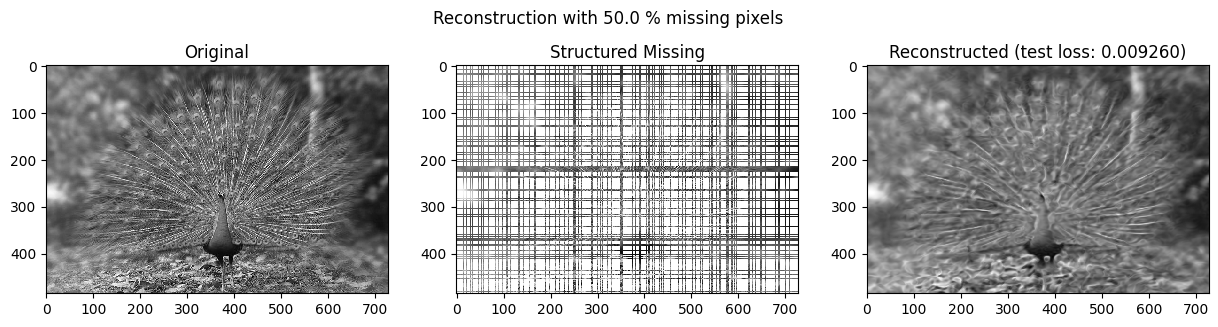

In [303]:
print(f"Test loss: {siren_test_loss:.6f}")

missing_img = siren_tracer.img.clone()
missing_img[siren_tracer.mask] = torch.nan
pred_img_siren = siren_model(siren_tracer.train_x.to(siren_config.device)).cpu().detach()

fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
ax[0].imshow(siren_tracer.img, cmap="gray", interpolation='none')
ax[0].set_title("Original")
ax[1].imshow(missing_img, cmap="gray", interpolation='none')
ax[1].set_title("Structured Missing" if siren_config.structured_missing else "Missing at random")
ax[2].imshow(pred_img_siren.squeeze(), cmap="gray", interpolation='none')
ax[2].set_title(f"Reconstructed (test loss: {siren_test_loss:.6f})");
fig.suptitle(f"Reconstruction with {siren_config.test_fraction*100} % missing pixels")

In [7]:
# # create calibration plot from test pixels, predicted pixels, and uncertainty
# test_pixels = siren_tracer.img[siren_tracer.mask].cpu()
# pred_pixels = pred_img_siren[siren_tracer.mask].cpu()
# pred_std = siren_tracer.pred_std[siren_tracer.mask].cpu()
# print(f"Test pixels: {test_pixels.shape} {test_pixels.numel()/siren_tracer.img.numel()*100:.2f}%")

# def confidence_to_z_score(confidence):
#     return scipy.stats.norm.ppf(1 - (1 - confidence) / 2)

# confidence_range = torch.linspace(0.01, 0.99, 99)
# z_scores = confidence_to_z_score(confidence_range)
# fraction_of_points = []
# quantile = []
# for idx, (z_score, confidence) in enumerate(zip(z_scores, confidence_range)):
#     quantile.append(confidence)
#     fraction = (((pred_pixels + z_score * pred_std) > test_pixels) * (test_pixels > (pred_pixels - z_score * pred_std))).to(torch.float).mean()
#     fraction_of_points.append(fraction)

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(quantile, fraction_of_points, label="SIREN (MC dropout)")
# ax.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
# ax.set_xlabel("Quantile")
# ax.set_ylabel("Fraction of points")
# ax.legend();

## MF for images

In [8]:
mf_config = Config()
mf_config.path = siren_config.path
mf_config.key = siren_config.key
mf_config.grayscale = siren_config.grayscale
mf_config.scale_down_factor = siren_config.scale_down_factor
mf_config.iterations = 3000
mf_config.lr = 1e-3
mf_config.regularization = "l2"
mf_config.lmd = 0.0
mf_config.test_fraction = siren_config.test_fraction
mf_config.structured_missing = siren_config.structured_missing
mf_config.device = siren_config.device
mf_config.output_dim = 1 if mf_config.grayscale else 3

# model specific
mf_config.model_class = MatrixFactorization
mf_config.image_shape = missing_img.shape
mf_config.rank = 60

Loss: 0.004042: 100%|██████████| 3000/3000 [00:09<00:00, 320.37it/s]


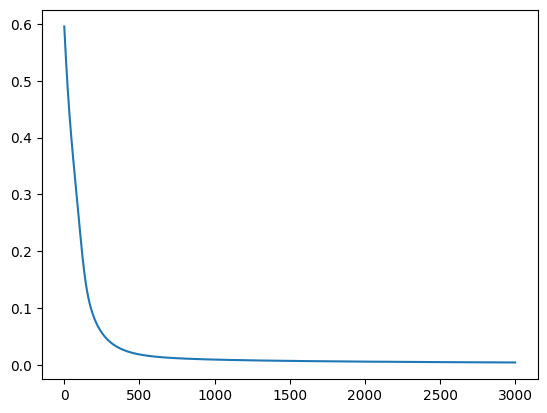

In [9]:
mf_model, mf_losses, mf_test_loss, mf_tracer = run(mf_config, Tracer())
plt.plot(mf_losses)

Test loss: 0.101517


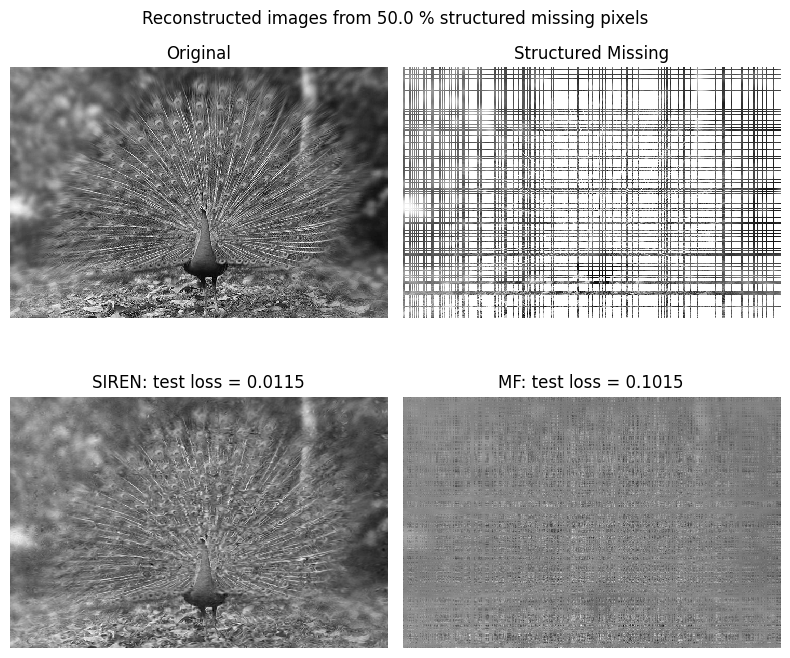

In [10]:
print(f"Test loss: {mf_test_loss:.6f}")

pred_img_mf = mf_model().cpu().detach().numpy()

#create a four figure layout where one figure is in center and others are below it
fig, ax = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 2]})

ax = ax.ravel()
for axis in ax.ravel():
    axis.axis('off')

ax[0].imshow(siren_tracer.img.squeeze(), cmap="gray", interpolation='none')
ax[0].set_title("Original")
ax[1].imshow(missing_img, cmap="gray", interpolation='none')
ax[1].set_title("Structured Missing" if siren_config.structured_missing else "Missing at random")
ax[2].imshow(pred_img_siren.squeeze(), cmap="gray", interpolation='none')
ax[2].set_title(f"SIREN: test loss = {siren_test_loss:.4f}")
ax[3].imshow(pred_img_mf, cmap="gray", interpolation='none')
ax[3].set_title(f"MF: test loss = {mf_test_loss:.4f}");
fig.suptitle(f"Reconstructed images from {mf_config.test_fraction * 100} % {('structured' if mf_config.structured_missing else 'random')} missing pixels");
fig.tight_layout()

## Siren for Audio

In [21]:
# read mp3 file
audio_path = "/home/patel_zeel/delhi_aq/data/audio/pirates_bgm.mp3"
audio, sr = librosa.load(audio_path, sr=None, mono=True, offset=0.0, duration=None)
audio = audio.reshape(-1, 1)[sr*5: sr*12]
audio.shape, sr

((308700, 1), 44100)

In [22]:
Audio(audio.ravel(), rate=sr)

In [26]:
siren_config = Config()
siren_config.path = "/home/patel_zeel/delhi_aq/data/audio/pirates_bgm.mp3"
siren_config.key = 0
siren_config.iterations = 500
siren_config.lr = 1e-4
siren_config.regularization = "l2"
siren_config.lmd = 0.0
siren_config.dropout = 0.0
siren_config.mc_dropout = False
siren_config.num_mc_samples = 500
siren_config.test_fraction = 0.1
siren_config.structured_missing = False
siren_config.device = "cuda:0"
siren_config.input_dim = 1
siren_config.output_dim = 1

# model specific
siren_config.model_class = SIREN
siren_config.layers = [256]*4
siren_config.activation_scale = 30.0

In [27]:
siren_model, siren_losses, siren_test_loss, siren_tracer = run_audio(siren_config, Tracer())

Loss: 0.002027: 100%|██████████| 500/500 [00:17<00:00, 27.84it/s]


In [28]:
print(f"Test loss: {siren_test_loss:.6f}")

missing_audio = siren_tracer.audio.clone()
missing_audio[siren_tracer.mask] = torch.nan
pred_audio_siren = siren_model(siren_tracer.train_x.to(siren_config.device)).cpu().detach()

Audio(pred_audio_siren.ravel(), rate=sr)

Test loss: 0.002318


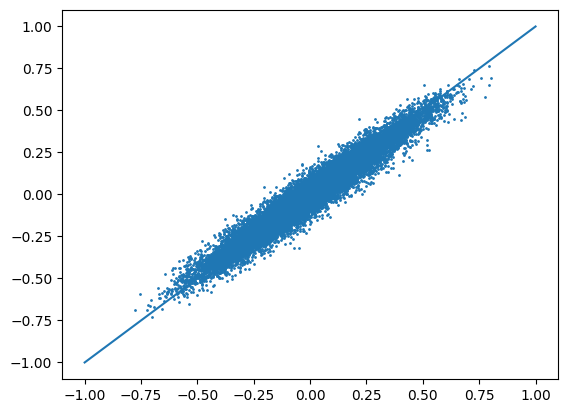

In [33]:
plt.plot([-1, 1], [-1, 1]);
plt.scatter(siren_tracer.audio[siren_tracer.mask], pred_audio_siren[siren_tracer.mask], s=1);

## Siren for AQ

In [307]:
siren_config = Config()
siren_config.key = 0
siren_config.iterations = 500
siren_config.lr = 1e-4
siren_config.regularization = "l2"
siren_config.lmd = 0.0
siren_config.dropout = 0.0
siren_config.mc_dropout = False
siren_config.num_mc_samples = 100
siren_config.test_fraction = 0.1
siren_config.structured_missing = False
siren_config.device = "cuda:0"
siren_config.input_dim = 2
siren_config.output_dim = 1
log_transform = True
plot = False

# model specific
siren_config.model_class = SIREN
siren_config.layers = [256]*4
siren_config.activation_scale = 30.0

In [308]:
aq_data = xr.open_dataset("/home/patel_zeel/delhi_aq/data/delhi_cpcb_2022.nc").to_dataframe().reset_index().set_index("time")
aq_data = aq_data.dropna(subset=["PM2.5"])
# select data from Jan 2022
# aq_data = aq_data.loc["2022-01"]

offset_random = 1234
N = 20
rmse_df = pd.DataFrame(columns=range(offset_random, N+offset_random))
for random_state in range(offset_random, N+offset_random):
    random_time_stamp = aq_data.sample(random_state=random_state).index[0]
    exp_df = aq_data.loc[random_time_stamp].set_index("station")
    print(exp_df.shape)

    x = exp_df[["latitude", "longitude"]].values
    y = exp_df[["PM2.5"]].values
    if log_transform:
        y = np.log(y)

    train_x_, test_x_, train_y_, test_y_ = train_test_split(x, y, test_size=0.2, random_state=random_state)
    x_scaler = MinMaxScaler((-1, 1))
    y_scaler = StandardScaler()
    train_x = x_scaler.fit_transform(train_x_)
    test_x = x_scaler.transform(test_x_)
    train_y = y_scaler.fit_transform(train_y_)
    test_y = y_scaler.transform(test_y_)

    print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
    
    siren_model, sire_losses, siren_test_loss = fit(siren_config, Tracer(), torch.tensor(train_x, dtype=DTYPE).to(siren_config.device), torch.tensor(train_y, dtype=DTYPE).to(siren_config.device), mask=None)
    
    models = {"LinReg": LinearRegression(), "3NN": KNeighborsRegressor(n_neighbors=3), "IDW": KNeighborsRegressor(n_neighbors=train_x.shape[0], weights="distance"), 
          "Mean": MeanModel(), "RF": RandomForestRegressor(random_state=0), "GB": GradientBoostingRegressor(random_state=0)}

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for name, model in models.items():
        pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
        pred_y_ = y_scaler.inverse_transform(pred_y)
        if log_transform:
            rmse = mean_squared_error(np.exp(test_y_), np.exp(pred_y_), squared=False)
        else:
            rmse = mean_squared_error(test_y_, pred_y_, squared=False)
        rmse_df.loc[name, random_state] = rmse
        # print(name, rmse)
        if plot:
            ax[0].scatter(test_x_[:, 0], test_y_.ravel(), s=20);
            tmp_idx = np.argsort(test_x_[:, 0])
            ax[0].plot(test_x_[tmp_idx, 0], pred_y_.ravel()[tmp_idx], label=name);

            tmp_idx = np.argsort(test_x_[:, 1])
            ax[1].scatter(test_x_[:, 1], test_y_.ravel(), s=20);
            ax[1].plot(test_x_[tmp_idx, 1], pred_y_.ravel()[tmp_idx], label=name);
        
    # siren predictions
    pred_y = siren_model(torch.tensor(test_x, dtype=DTYPE).to(siren_config.device)).cpu().detach().numpy()
    pred_y_ = y_scaler.inverse_transform(pred_y)
    if log_transform:
        siren_rmse = mean_squared_error(np.exp(test_y_), np.exp(pred_y_), squared=False)
    else:
        siren_rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    rmse_df.loc["SIREN", random_state] = siren_rmse
    if plot:
        ax[0].scatter(test_x_[:, 0], test_y_.ravel(), s=20);
        tmp_idx = np.argsort(test_x_[:, 0])
        ax[0].plot(test_x_[tmp_idx, 0], pred_y_.ravel()[tmp_idx], label="SIREN");

        tmp_idx = np.argsort(test_x_[:, 1])
        ax[1].scatter(test_x_[:, 1], test_y_.ravel(), s=20);
        ax[1].plot(test_x_[tmp_idx, 1], pred_y_.ravel()[tmp_idx], label="SIREN");

        ax[0].legend(bbox_to_anchor=(1, 1));
        ax[1].legend(bbox_to_anchor=(1, 1));
        fig.tight_layout()

(38, 23)
(30, 2) (8, 2) (30, 1) (8, 1)


Loss: 0.096291: 100%|██████████| 500/500 [00:02<00:00, 218.35it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(33, 23)
(26, 2) (7, 2) (26, 1) (7, 1)


Loss: 0.000000: 100%|██████████| 500/500 [00:02<00:00, 208.02it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(37, 23)
(29, 2) (8, 2) (29, 1) (8, 1)


Loss: 0.001554: 100%|██████████| 500/500 [00:02<00:00, 216.37it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(36, 23)
(28, 2) (8, 2) (28, 1) (8, 1)


Loss: 0.089753: 100%|██████████| 500/500 [00:02<00:00, 212.70it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(36, 23)
(28, 2) (8, 2) (28, 1) (8, 1)


Loss: 0.001337: 100%|██████████| 500/500 [00:02<00:00, 217.25it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(38, 23)
(30, 2) (8, 2) (30, 1) (8, 1)


Loss: 0.010628: 100%|██████████| 500/500 [00:02<00:00, 214.93it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(36, 23)
(28, 2) (8, 2) (28, 1) (8, 1)


Loss: 0.000076: 100%|██████████| 500/500 [00:02<00:00, 213.94it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(36, 23)
(28, 2) (8, 2) (28, 1) (8, 1)


Loss: 0.000000: 100%|██████████| 500/500 [00:02<00:00, 215.03it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(39, 23)
(31, 2) (8, 2) (31, 1) (8, 1)


Loss: 0.000009: 100%|██████████| 500/500 [00:02<00:00, 216.14it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(32, 23)
(25, 2) (7, 2) (25, 1) (7, 1)


Loss: 0.000250: 100%|██████████| 500/500 [00:02<00:00, 215.95it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(38, 23)
(30, 2) (8, 2) (30, 1) (8, 1)


Loss: 0.003019: 100%|██████████| 500/500 [00:02<00:00, 215.84it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(39, 23)
(31, 2) (8, 2) (31, 1) (8, 1)


Loss: 0.000107: 100%|██████████| 500/500 [00:02<00:00, 214.57it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(33, 23)
(26, 2) (7, 2) (26, 1) (7, 1)


Loss: 0.000012: 100%|██████████| 500/500 [00:02<00:00, 220.74it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(37, 23)
(29, 2) (8, 2) (29, 1) (8, 1)


Loss: 0.000014: 100%|██████████| 500/500 [00:02<00:00, 216.39it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(38, 23)
(30, 2) (8, 2) (30, 1) (8, 1)


Loss: 0.006248: 100%|██████████| 500/500 [00:02<00:00, 189.98it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(36, 23)
(28, 2) (8, 2) (28, 1) (8, 1)


Loss: 0.150902: 100%|██████████| 500/500 [00:02<00:00, 190.85it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(38, 23)
(30, 2) (8, 2) (30, 1) (8, 1)


Loss: 0.104735: 100%|██████████| 500/500 [00:02<00:00, 190.73it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 23)
(28, 2) (7, 2) (28, 1) (7, 1)


Loss: 0.013710: 100%|██████████| 500/500 [00:02<00:00, 194.55it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(39, 23)
(31, 2) (8, 2) (31, 1) (8, 1)


Loss: 0.000132: 100%|██████████| 500/500 [00:02<00:00, 190.47it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(37, 23)
(29, 2) (8, 2) (29, 1) (8, 1)


Loss: 0.000000: 100%|██████████| 500/500 [00:02<00:00, 196.66it/s]
/tmp/ipykernel_3106444/2464659727.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pred_y = model.fit(train_x, train_y).predict(test_x).reshape(-1, 1)
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [309]:
rmse_df

,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253
LinReg,55.123902,18.199137,38.996781,67.848209,15.190695,24.72413,38.083755,10.453311,28.007749,6.690188,70.713712,15.307168,13.016813,58.502756,33.403414,6.276695,8.979026,194.898482,46.824649,13.94447
3NN,51.840551,15.752892,46.087997,70.040575,16.780544,37.54462,41.872234,14.919461,19.10835,8.51084,90.071639,17.520039,12.875573,57.028041,43.26539,5.562242,14.270434,199.990524,45.051587,11.934114
IDW,53.250698,15.11673,34.344208,50.992211,15.034262,38.12861,40.370636,9.822552,28.794267,8.248879,67.972884,20.732208,12.950252,60.802903,40.964807,5.707539,11.818991,197.728984,46.955039,13.658548
Mean,55.988007,14.768894,33.541987,49.139046,14.879392,41.910578,41.820436,11.816572,27.276324,8.933138,67.173186,15.873319,12.388073,61.675571,37.783062,6.387251,16.134007,197.361543,42.558937,13.763965
RF,59.193812,16.396796,37.805869,66.788243,17.017409,28.188952,36.342361,15.512875,74.912348,7.198333,74.458094,20.85122,16.436067,54.128078,53.984669,4.466901,13.954826,198.860022,49.829212,12.517068
GB,70.452106,18.021911,40.634294,73.412594,16.744461,36.365827,36.189003,20.3051,99.442262,8.364913,80.087471,26.23922,17.657656,56.694299,57.076727,6.315158,19.064128,196.71227,59.399663,13.838012
SIREN,56.840123,16.772444,33.349021,57.068106,15.081868,48.279134,43.716532,17.879944,30.523234,12.227511,72.216831,26.802602,13.128571,59.351726,67.769914,9.483744,21.061499,194.988838,50.291004,12.451656


In [310]:
# create rankings
rank_df = pd.DataFrame(columns=rmse_df.columns)
for col in rmse_df.columns:
    rank_df[col] = rmse_df[col].rank()

# add mean rank
rank_df["Mean"] = rank_df.mean(axis=1)
rank_df.sort_values("Mean")

,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,...,1245,1246,1247,1248,1249,1250,1251,1252,1253,Mean
LinReg,3.0,7.0,5.0,5.0,4.0,1.0,3.0,2.0,3.0,1.0,...,1.0,4.0,4.0,1.0,4.0,1.0,1.0,3.0,7.0,3.15
IDW,2.0,2.0,3.0,2.0,2.0,5.0,4.0,1.0,4.0,3.0,...,4.0,3.0,6.0,3.0,3.0,2.0,5.0,4.0,4.0,3.20
Mean,4.0,1.0,2.0,1.0,1.0,6.0,5.0,3.0,2.0,6.0,...,2.0,1.0,7.0,2.0,6.0,5.0,4.0,1.0,5.0,3.25
3NN,1.0,3.0,7.0,6.0,6.0,4.0,6.0,4.0,1.0,5.0,...,3.0,2.0,3.0,4.0,2.0,4.0,7.0,2.0,1.0,3.90
RF,6.0,4.0,4.0,4.0,7.0,2.0,2.0,5.0,6.0,2.0,...,5.0,6.0,1.0,5.0,1.0,3.0,6.0,5.0,3.0,4.10
SIREN,5.0,5.0,1.0,3.0,3.0,7.0,7.0,6.0,5.0,7.0,...,7.0,5.0,5.0,7.0,7.0,7.0,2.0,6.0,2.0,5.05
GB,7.0,6.0,6.0,7.0,5.0,3.0,1.0,7.0,7.0,4.0,...,6.0,7.0,2.0,6.0,5.0,6.0,3.0,7.0,6.0,5.35


### Missing at random

In [411]:
siren_config = Config()
siren_config.key = 0
siren_config.iterations = 1000
siren_config.lr = 1e-4
siren_config.regularization = "l2"
siren_config.lmd = 0.0
siren_config.dropout = 0.0
siren_config.mc_dropout = False
siren_config.num_mc_samples = 100
siren_config.test_fraction = 0.9
siren_config.structured_missing = False
siren_config.device = "cuda:0"
siren_config.input_dim = 3
siren_config.output_dim = 1
log_transform = False
plot = False
random_state = 0

# model specific
siren_config.model_class = SIREN
siren_config.layers = [256]*4
siren_config.activation_scale = 30.0

In [412]:
aq_data = xr.open_dataset("/home/patel_zeel/delhi_aq/data/delhi_cpcb_2022.nc").to_dataframe().reset_index().set_index("time", drop=False)
aq_data = aq_data.dropna(subset=["PM2.5"])
aq_data = aq_data[~aq_data.station.isin(['IHBAS, Dilshad Garden, Delhi - CPCB',
 'DTU, Delhi - CPCB',
 'Burari Crossing, Delhi - IMD',
 'Chandni Chowk, Delhi - IITM',
 'Lodhi Road, Delhi - IITM'])]

aq_data["float_time"] = aq_data.time.astype(int)/1e18

# print(aq_data['float_time'])
x = aq_data[["latitude", "longitude", "float_time"]].values
y = aq_data[["PM2.5"]].values
if log_transform:
    y = np.log(y)

train_x_, test_x_, train_y_, test_y_ = train_test_split(x, y, test_size=siren_config.test_fraction, random_state=random_state)
x_scaler = MinMaxScaler((-10, 10))
y_scaler = StandardScaler()
train_x = x_scaler.fit_transform(train_x_)
test_x = x_scaler.transform(test_x_)
train_y = y_scaler.fit_transform(train_y_)
test_y = y_scaler.transform(test_y_)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(28801, 3) (259217, 3) (28801, 1) (259217, 1)


In [413]:
siren_model, sire_losses, siren_test_loss = fit(siren_config, Tracer(), torch.tensor(train_x, dtype=DTYPE).to(siren_config.device), 
                                                torch.tensor(train_y, dtype=DTYPE).to(siren_config.device), mask=None)

Loss: 0.006738: 100%|██████████| 1000/1000 [00:05<00:00, 172.43it/s]


In [414]:
pred_y = siren_model(torch.tensor(test_x, dtype=DTYPE).to(siren_config.device)).cpu().detach().numpy()
pred_y_ = y_scaler.inverse_transform(pred_y).reshape(-1, 1)
if log_transform:
    siren_rmse = mean_squared_error(np.exp(test_y_), np.exp(pred_y_), squared=False)
else:
    siren_rmse = mean_squared_error(test_y_, pred_y_, squared=False)
print(siren_rmse)

# train rmse
pred_y = siren_model(torch.tensor(train_x, dtype=DTYPE).to(siren_config.device)).cpu().detach().numpy()
pred_y_ = y_scaler.inverse_transform(pred_y).reshape(-1, 1)
if log_transform:
    siren_rmse = mean_squared_error(np.exp(train_y_), np.exp(pred_y_), squared=False)
else:
    siren_rmse = mean_squared_error(train_y_, pred_y_, squared=False)
print("Train_RMSE", siren_rmse)

78.74893702937862
Train_RMSE 7.023095295025958


In [415]:
rf = RandomForestRegressor(n_estimators=1000, random_state=random_state, n_jobs=-1)
rf.fit(train_x, train_y)
pred_y = rf.predict(test_x).reshape(-1, 1)
pred_y_ = y_scaler.inverse_transform(pred_y)
print(mean_squared_error(test_y_, pred_y_, squared=False))

# train rmse
pred_y = rf.predict(train_x).reshape(-1, 1)
pred_y_ = y_scaler.inverse_transform(pred_y)
print("Train_RMSE", mean_squared_error(train_y_, pred_y_, squared=False))

/tmp/ipykernel_3106444/1230142230.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_x, train_y)


36.048098802511
Train_RMSE 13.570715354355382


## End

In [392]:
shape = plt.imread("/home/patel_zeel/delhi_aq/data/images/dog_2.jpg").shape

(1365, 2048, 3)